In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist

import gymnasium as gym


## REINFORCE algorithm
while not converged:

    1. sample N trajectories using current policy and observe returns

    2. estimate policy gradient as average over trajectories
    
    3. update policy using gradient ascent


In [349]:
class Agent:

    def __init__(self, policy, discount_rate=.99, policy_lr=.01): 
        self.policy = policy
        self.discount_rate = discount_rate
        self.optimiser = optim.SGD(self.policy.parameters(), lr=policy_lr)
        ## TODO: convert this to tensorboard logger?
        self.batch_results = dict()
        ## setup 
        self.init_records()

    def init_records(self):
        self.records = {
            'state':[],
            'action':[],
            'action_log_prob': [],
            'next_state':[],
            'reward': [],
            'done':[]
        }

    def append_record(self, state, action, log_prob, next_state, reward, done):
        self.records['state'].append(state)
        self.records['action'].append(action)
        self.records['action_log_prob'].append(log_prob)
        self.records['next_state'].append(next_state)
        self.records['reward'].append(reward)
        self.records['done'].append(done)

    def log_batch_results(self, batch, log_probs, rewards, returns, policy_gradient, episode_len):
        self.batch_results[batch] = {
            'log_probs':log_probs,
            'rewards': rewards,
            'returns': returns,
            'policy_gradient': policy_gradient,
            'episode_len': episode_len
        }

    def train(self, env, num_iters, batch_size):
        
        for batch in range(num_iters):
            self.optimiser.zero_grad()
            self.sample_trajectory(env, batch_size)

            ## get values to log
            log_probs = torch.stack(self.records['action_log_prob']) 
            dones = torch.tensor(self.records['done'], dtype=torch.int8)
            rewards = torch.tensor(self.records['reward'])
            returns = calc_returns(rewards, dones, self.discount_rate)
            policy_gradient = (-log_probs*returns).mean()

            ## backprop
            policy_gradient.backward()
            self.optimiser.step()

            ## log for post training review
            self.log_batch_results(
                batch=batch,
                log_probs=log_probs.mean().detach().numpy(),
                rewards=rewards.sum().numpy() / batch_size,
                returns=returns.mean().numpy(),
                policy_gradient=policy_gradient.detach().numpy(),
                episode_len = rewards.size(-1) / batch_size
            )

            ## clear out records for next batch
            self.init_records()

    def act(self, x):
        action_logits = self.policy(x)
        return dist.Categorical(logits=action_logits)

    def sample_trajectory(self, env: gym.Env, n_samples:int):

        for episode in range(n_samples):
            state, info = env.reset()
            done = False
            while not done:
                
                action_dist = self.act(state) 
                action = action_dist.sample()
                action_log_prob = action_dist.log_prob(action)
                next_state, reward, terminated, truncated, info = env.step(action.detach().numpy())
                done = terminated or truncated

                self.append_record(
                    state, 
                    action, 
                    action_log_prob,
                    next_state, 
                    reward, 
                    done
                )

                state = next_state

class Policy(nn.Module):

    def __init__(self, n_features, n_actions, n_intermediate=10):
        super().__init__()
        self.n_features = n_features
        self.n_actions = n_actions

        self.net = nn.Sequential(
            nn.Linear(n_features, n_intermediate),
            nn.ReLU(),
            nn.Linear(n_intermediate, n_actions)
        )

    def forward(self, x):
        x = torch.tensor(x)
        x = self.net(x)
        return x

## keep separate to enable general use
def calc_returns(rewards, dones, discount_rate):
    returns = torch.zeros_like(rewards)
    T = returns.size(-1)
    returns[-1] = rewards[-1] + discount_rate*returns[-1].sum() * (1-dones[-1])
    for t in reversed(range(T-1)):
        returns[t] = rewards[t] + discount_rate*returns[t+1].sum() * (1-dones[t])
    return returns

In [350]:
policy = Policy(4, 2, 4)
agent = Agent(policy, policy_lr=.3)
env = gym.make('CartPole-v1')
agent.train(env, num_iters=75, batch_size=20)

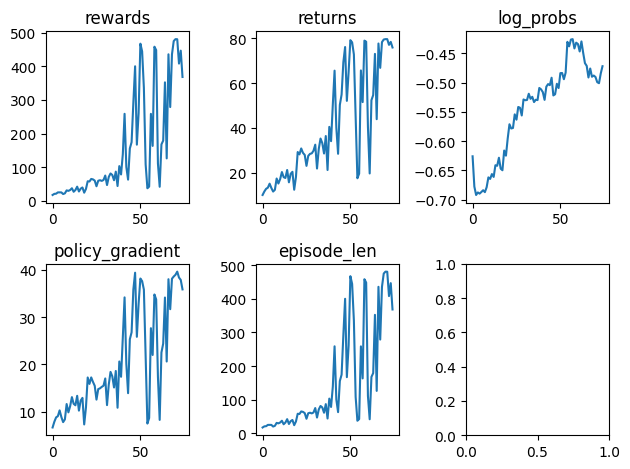

In [351]:
import matplotlib.pyplot as plt

batch_results = agent.batch_results
results = {
    'log_probs' : [batch_results[i]['log_probs'] for i in batch_results.keys()],
    'rewards' : [batch_results[i]['rewards'] for i in batch_results.keys()],
    'returns' : [batch_results[i]['returns'] for i in batch_results.keys()],
    'policy_gradient' : [batch_results[i]['policy_gradient'] for i in batch_results.keys()],
    'episode_len' : [batch_results[i]['episode_len'] for i in batch_results.keys()],
}

fig, ax = plt.subplots(2,3)
ax = ax.flatten()
for i, res in enumerate(['rewards', 'returns', 'log_probs', 'policy_gradient', 'episode_len']):
    ax[i].plot(
        list(batch_results.keys()),
        results[res]
    )
    ax[i].set_title(res)
plt.tight_layout()
plt.show();

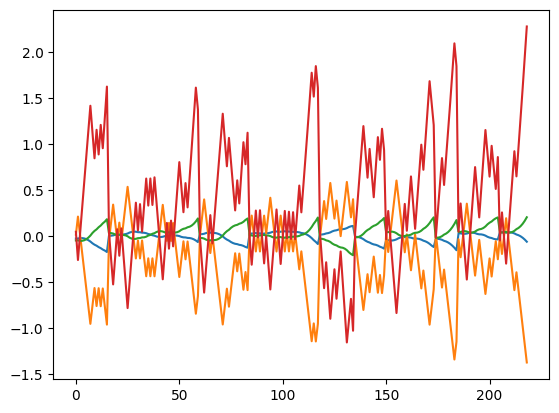

In [20]:
import numpy as np
import matplotlib.pyplot as plt
states = np.array(samples['state'])
plt.plot(range(states.shape[0]), states)
plt.show();